In [1]:
import numpy as np
import scipy
import poppy
if poppy.accel_math._USE_CUPY:
    import cupy as xp
    import cupyx.scipy as _scipy
else:
    xp = np
    _scipy = scipy
    
from poppy.poppy_core import PlaneType

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display

import zosapi
from System import Enum,Int32,Double,Array
from pathlib import Path

from importlib import reload

# import logging, sys
# poppy_log = logging.getLogger('poppy')
# poppy_log.setLevel('DEBUG')
# logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

# poppy_log.disabled = True

# import warnings
# warnings.filterwarnings("ignore")

from prop_models import full, compact, agpm
reload(full)
reload(compact)
reload(agpm)

from wfsc_1dm import efc, pwp, utils

from imshows import imshow1, imshow2, imshow3

pupil_diam = 6.5*u.m
dm_diam = 10.2*u.mm
wavelength_c = 650e-9*u.m


# Generate pointing error samples

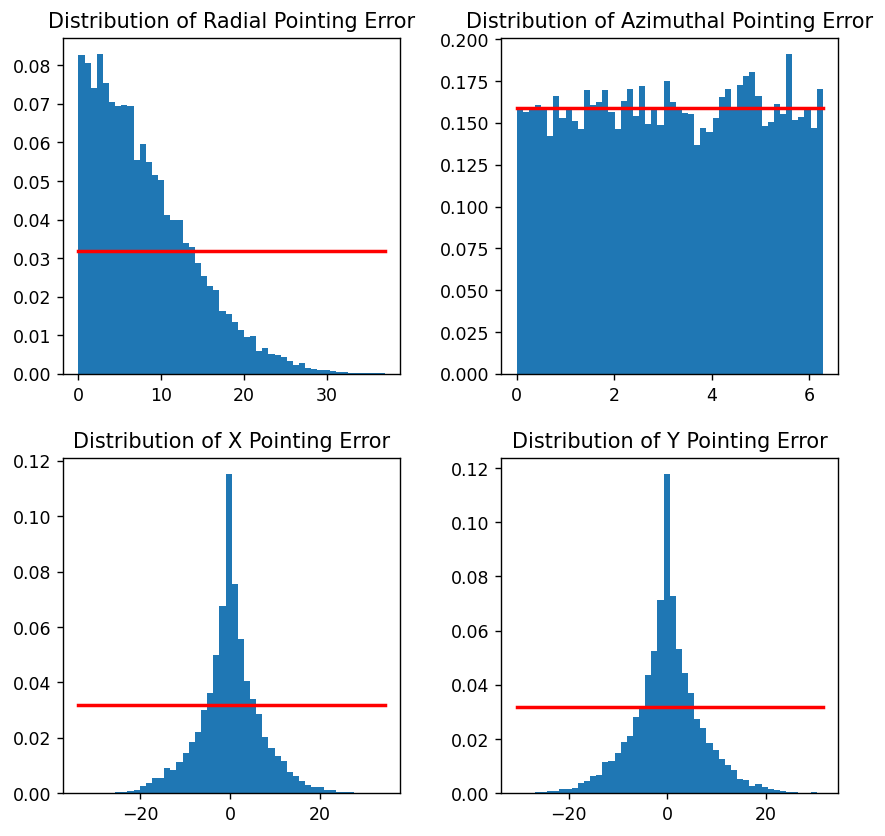

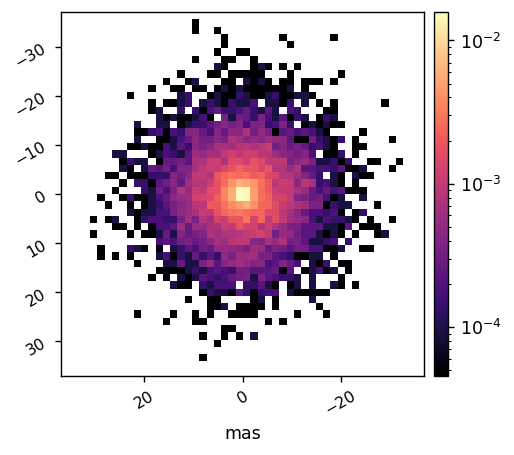

In [2]:
pointing_error = 10*u.mas # STD of pointing error
mean = 0

seed = 12
Nsamps = 10000

pointing_r = np.abs(np.random.default_rng(seed).normal(mean, pointing_error.to_value(u.mas), Nsamps))
pointing_th = np.random.default_rng(seed).uniform(low=0.0, high=2*np.pi, size=Nsamps)

pointing_x = pointing_r*np.cos(pointing_th)
pointing_y = pointing_r*np.sin(pointing_th)

pointing = np.array([pointing_x, pointing_y]).T*u.mas

nbins = 50

fig = plt.figure(figsize=(8,8), dpi=125)

plt.subplot(221)
count, bins, ignored = plt.hist(pointing_r, nbins, density=True)
plt.plot(bins, np.ones_like(bins)/(np.pi*pointing_error.to_value(u.mas)), linewidth=2, color='r')
plt.title('Distribution of Radial Pointing Error')

plt.subplot(222)
count, bins, ignored = plt.hist(pointing_th, nbins, density=True)
plt.plot(bins, 1/(2*np.pi)*np.ones_like(bins), linewidth=2, color='r')
plt.title('Distribution of Azimuthal Pointing Error')

plt.subplot(223)
count, bins, ignored = plt.hist(pointing_x, nbins, density=True)
plt.plot(bins, np.ones_like(bins)/(np.pi*pointing_error.to_value(u.mas)), linewidth=2, color='r')
plt.title('Distribution of X Pointing Error')

plt.subplot(224)
count, bins, ignored = plt.hist(pointing_y, nbins, density=True)
plt.plot(bins, np.ones_like(bins)/(np.pi*pointing_error.to_value(u.mas)), linewidth=2, color='r')
plt.title('Distribution of Y Pointing Error')

plt.subplots_adjust(wspace=0.3, hspace=0.25)
plt.close()
display(fig)

rmax = np.max(pointing_r)
# fig = plt.figure()
h, xedges, yedges, im = plt.hist2d(pointing_x, pointing_y, bins=nbins, range=[[-rmax, rmax], [-rmax, rmax]], density=True)
plt.close()

imshow1(h, lognorm=True, pxscl=(xedges[0]-xedges[1]), xlabel='mas')


# Define the static high-order surface errors for each telescope optic.
The extent of each optic is found by using the Zemax model dimensions for the apertures.

Oversampling > 2x suggested for reliable results in Fresnel propagation.


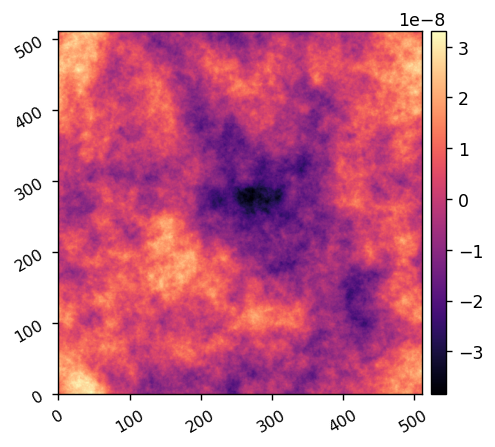

Oversampling > 2x suggested for reliable results in Fresnel propagation.


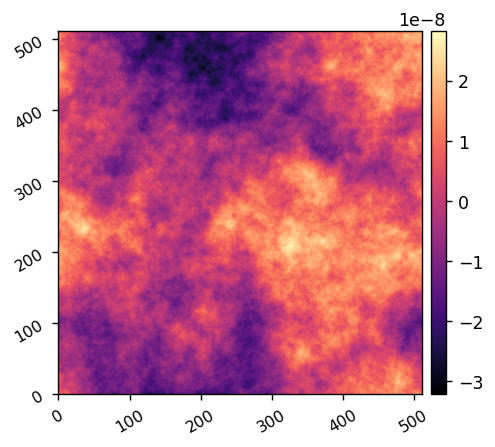

Oversampling > 2x suggested for reliable results in Fresnel propagation.


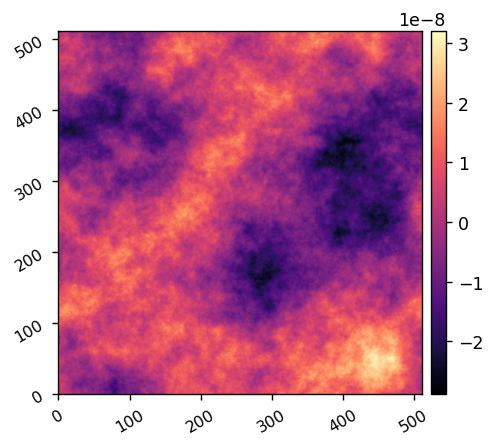

Oversampling > 2x suggested for reliable results in Fresnel propagation.


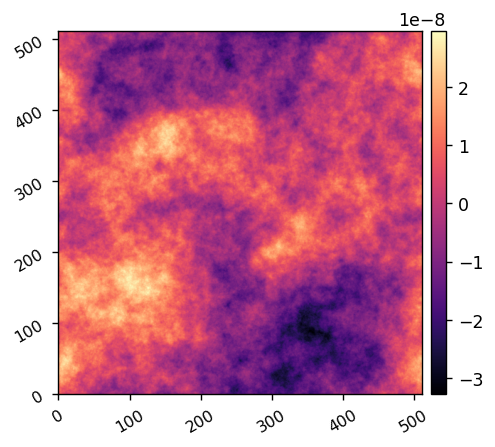

In [3]:
m1_diam = 6.5*u.m
m2_diam = 700*u.mm
m3_diam = 800*u.mm # using the maximum dimension of M3 to define the surface opd
m3_dims = [800*u.mm, 700*u.mm]
m4_diam = 100*u.mm

seeds = (1,2,3,4)

npix_surfs = 512 # use high-sampling when we are defining the surface errors
oversample = 1

rms = 10*u.nm

m1surf0 = poppy.StatisticalPSDWFE('M1 Surface OPD', index=3.0, wfe=rms, radius=m1_diam/2, seed=seeds[0])
m1wf = poppy.FresnelWavefront(beam_radius=m1_diam/2, npix=npix_surfs, oversample=oversample)
m1errs = m1surf0.get_opd(m1wf) # m1 
imshow1(m1errs)

m2surf0 = poppy.StatisticalPSDWFE('M2 Surface OPD', index=3.0, wfe=rms, radius=m2_diam/2, seed=seeds[1])
m2wf = poppy.FresnelWavefront(beam_radius=m2_diam/2, npix=npix_surfs, oversample=oversample)
m2errs = m2surf0.get_opd(m2wf) # m1 
imshow1(m2errs)

m3surf0 = poppy.StatisticalPSDWFE('M3 Surface OPD', index=3.0, wfe=rms, radius=m3_diam/2, seed=seeds[2])
m3wf = poppy.FresnelWavefront(beam_radius=m3_diam/2, npix=npix_surfs, oversample=oversample)
m3errs = m3surf0.get_opd(m3wf) # m1 
imshow1(m3errs)

m4surf0 = poppy.StatisticalPSDWFE('M4 Surface OPD', index=3.0, wfe=rms, radius=m4_diam/2, seed=seeds[3])
m4wf = poppy.FresnelWavefront(beam_radius=m4_diam/2, npix=npix_surfs, oversample=oversample)
m4errs = m4surf0.get_opd(m4wf)
imshow1(m4errs)


# Select a pointing error sample from the data and use the ZOSAPI to calculate the shift of the beam on M2, M3, and M4. 

In [4]:
zos_path = Path('C:/Users/Kian/Projects/apra-howfsc-fpgas/zemax_models/OFFAXIS_TMA.zos')
display(zos_path)

zos = zosapi.App()
ZOSAPI = zos.ZOSAPI
TheSystem = zos.TheSystem
TheSystem.LoadFile(str(zos_path),False)

wave = TheSystem.SystemData.Wavelengths.GetWavelength(1).Wavelength * 1e-6
display(wave)



WindowsPath('C:/Users/Kian/Projects/apra-howfsc-fpgas/zemax_models/OFFAXIS_TMA.zos')

Connected to OpticStudio at: c:\program files\ansys zemax opticstudio 2023 r1.00


6.5e-07

In [7]:
# surfaces we want the ray0 data at are 3, 4, 6, and 8
LDE = TheSystem.LDE

m1_ind = 4
m2_ind = 5
int_fp_ind = 6
m3_ind = 7
m4_ind = 9
fp_ind = 13

M1 = LDE.GetSurfaceAt(m1_ind)
M2 = LDE.GetSurfaceAt(m2_ind)
INTFP = LDE.GetSurfaceAt(int_fp_ind)
M3 = LDE.GetSurfaceAt(m3_ind)
M4 = LDE.GetSurfaceAt(m4_ind)

m1_m2 = np.float64(M1.Thickness)
display(m1_m2)

Hx = 8.334999999999999E-002
Hy = 6.665000000000000E-002
H = np.sqrt(Hx**2 + Hy**2)

# get the real ray0 coordinates on each optic
MFE = TheSystem.MFE

m1_rx0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m1_ind, 1, 0, 0, 0, 0, 0, 0)
m1_ry0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m1_ind, 1, 0, 0, 0, 0, 0, 0)
m1_ray0 = np.array([m1_rx0,m1_ry0])*u.mm

m2_rx0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m2_ind, 1, 0, 0, 0, 0, 0, 0)
m2_ry0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m2_ind, 1, 0, 0, 0, 0, 0, 0)
m2_ray0 = np.array([m2_rx0,m2_ry0])*u.mm

m3_rx0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m3_ind, 1, 0, 0, 0, 0, 0, 0)
m3_ry0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m3_ind, 1, 0, 0, 0, 0, 0, 0)
m3_ray0 = np.array([m3_rx0,m3_ry0])*u.mm

m4_rx0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m4_ind, 1, 0, 0, 0, 0, 0, 0)
m4_ry0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m4_ind, 1, 0, 0, 0, 0, 0, 0)
m4_ray0 = np.array([m4_rx0,m4_ry0])*u.mm

print('Ray Coordinates:', m1_ray0, m2_ray0, m3_ray0, m4_ray0)

-16638.12910134875

Ray Coordinates: [   0.         4030.15527516] mm [  0.         388.73133484] mm [  0.         285.00421099] mm [  0.         -38.10654925] mm


In [18]:
p = pointing.to_value(u.degree)
i = 2
display(p[i])

# apply pointing error by altering the field bias
# tilt_about_x.set_Value(str(p[i][0]))
# tilt_about_y.set_Value(str(p[i][1]))

hx = p[i][0]/H
hy = p[i][1]/H
print(hx, hy)

# get the real ray coordinates on each optic
m1_rx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m1_ind, 1, hx, hy, 0, 0, 0, 0)
m1_ry = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m1_ind, 1, hx, hy, 0, 0, 0, 0)
m1_ray = np.array([m1_rx,m1_ry])*u.mm

m2_rx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m2_ind, 1, hx, hy, 0, 0, 0, 0)
m2_ry = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m2_ind, 1, hx, hy, 0, 0, 0, 0)
m2_ray = np.array([m2_rx,m2_ry])*u.mm

m3_rx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m3_ind, 1, hx, hy, 0, 0, 0, 0)
m3_ry = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m3_ind, 1, hx, hy, 0, 0, 0, 0)
m3_ray = np.array([m3_rx,m3_ry])*u.mm

m4_rx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m4_ind, 1, hx, hy, 0, 0, 0, 0)
m4_ry = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m4_ind, 1, hx, hy, 0, 0, 0, 0)
m4_ray = np.array([m4_rx,m4_ry])*u.mm
print('Ray Coordinates:', m1_ray, m2_ray, m3_ray, m4_ray)

m1_shift = m1_ray0 - m1_ray
m2_shift = m2_ray0 - m2_ray
m3_shift = m3_ray0 - m3_ray
m4_shift = m4_ray0 - m4_ray
print('Shifts:', m1_shift, m2_shift, m3_shift, m4_shift)

array([7.66496459e-07, 1.91205404e-06])

7.182222781603199e-06 1.7916322963805414e-05
Ray Coordinates: [-2.97378738e-06  4.03015527e+03] mm [2.24952863e-04 3.88731896e+02] mm [2.73231717e-03 2.85011007e+02] mm [-3.82182289e-06 -3.81065781e+01] mm
Shifts: [2.97378738e-06 7.41680697e-06] mm [-0.00022495 -0.0005615 ] mm [-0.00273232 -0.00679627] mm [3.82182289e-06 2.88314700e-05] mm


# Shift the surface errors by the required amount of pixels from the calculated beam shift. 

Oversampling > 2x suggested for reliable results in Fresnel propagation.


Pixels to shift in x and y: -0.000164536950961502 -0.00041069373692153015


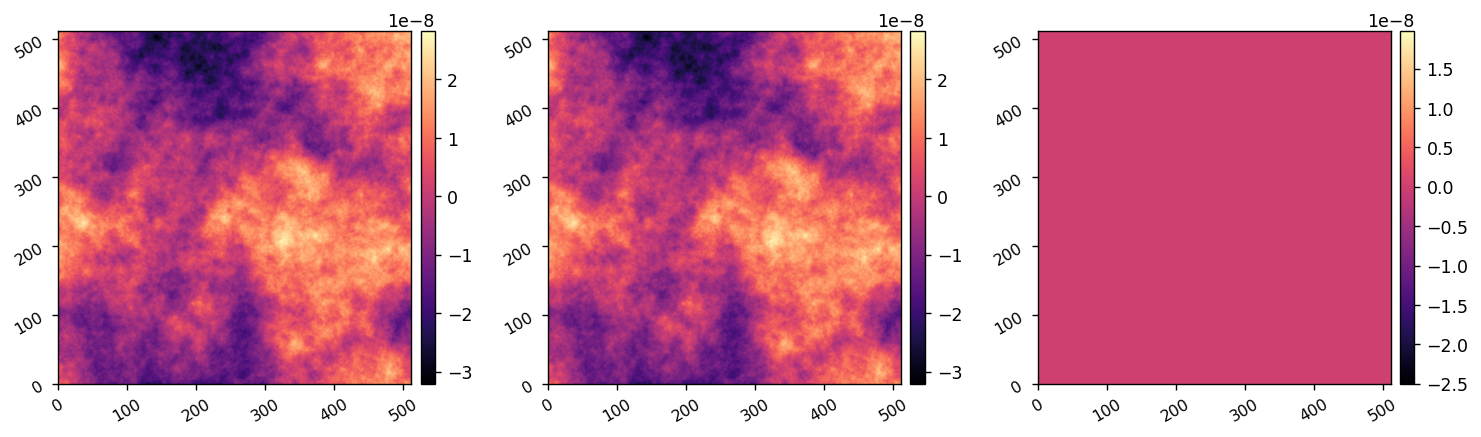

Oversampling > 2x suggested for reliable results in Fresnel propagation.


Pixels to shift in x and y: -0.0017486829879697838 -0.004349611688521691


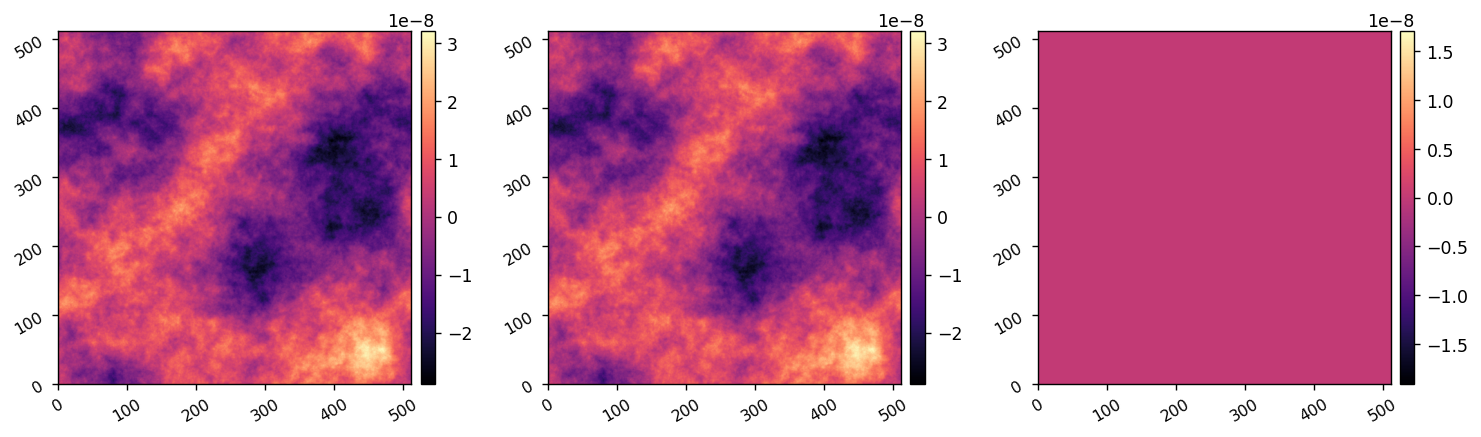

In [19]:
def shift_surface_errors(surf_element, npix, shift=np.array([0,0])*u.m):
    wf = poppy.FresnelWavefront(beam_radius=surf_element.radius, npix=npix, oversample=1, wavelength=wavelength_c)
    surf_opd = surf_element.get_opd(wf)
    
    x_shift_pix = shift[0].to_value(u.m)/wf.pixelscale.to_value(u.m/u.pix)
    y_shift_pix = shift[1].to_value(u.m)/wf.pixelscale.to_value(u.m/u.pix)
    print('Pixels to shift in x and y:', x_shift_pix, y_shift_pix)
    shifted_surf_opd = _scipy.ndimage.shift(surf_opd, (y_shift_pix, x_shift_pix))
    new_surf_element = poppy.ArrayOpticalElement(opd=shifted_surf_opd)
    return new_surf_element

m2surf = shift_surface_errors(m2surf0, npix_surfs, shift=m2_shift)
imshow3(m2errs, m2surf.opd, m2errs-m2surf.opd)

m3surf = shift_surface_errors(m3surf0, npix_surfs, shift=m3_shift)
imshow3(m3errs, m3surf.opd, m3errs-m3surf.opd)

# Also use the ZOSAPI to find the low-order aberrations of the telescope optical system for perfect pointing and with the pointing error

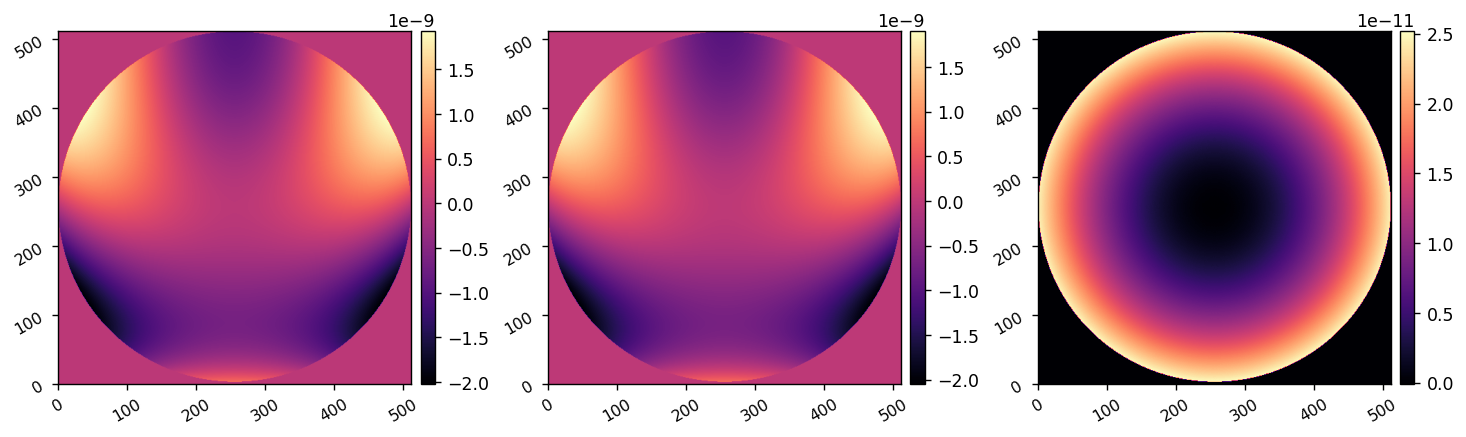

In [22]:
CB = LDE.GetSurfaceAt(3) # the coordinate break defining the system field bias
tilt_about_x = CB.GetCellAt(13)
tilt_about_y = CB.GetCellAt(14)

# Get the opd of the on-axis field
tilt_about_x.set_Value(str(0))
tilt_about_y.set_Value(str(0))

WFMap = TheSystem.Analyses.New_Analysis(ZOSAPI.Analysis.AnalysisIDM.WavefrontMap)
WFMapSettings = WFMap.GetSettings()
WFMapSettings.Sampling = ZOSAPI.Analysis.SampleSizes.S_1024x1024

WFMap.ApplyAndWaitForCompletion() # make sure the settings have been applied
WFMapResults = WFMap.GetResults() # get results

wfe0 = np.flip(np.array(WFMapResults.GetDataGrid(0).Values)) * wave
wfe0[np.isnan(wfe0)] = 0

tilt_about_x.set_Value(str(p[i][0]))
tilt_about_y.set_Value(str(p[i][1]))

WFMap = TheSystem.Analyses.New_Analysis(ZOSAPI.Analysis.AnalysisIDM.WavefrontMap)
WFMapSettings = WFMap.GetSettings()
WFMapSettings.Sampling = ZOSAPI.Analysis.SampleSizes.S_1024x1024

WFMap.ApplyAndWaitForCompletion() # make sure the settings have been applied
WFMapResults = WFMap.GetResults() # get results

wfe = np.flip(np.array(WFMapResults.GetDataGrid(0).Values)) * wave
wfe[np.isnan(wfe)] = 0

# reset the tilt of the system
tilt_about_x.set_Value(str(0))
tilt_about_y.set_Value(str(0))

imshow3(wfe0, wfe, wfe0-wfe)



# Define the optical system and propagate to the exit pupil to obtain a combination of the high-order and low-order aberrations in the system. 

In [24]:
m1_rgx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGX, m1_ind, 1, 0, 0, 0, 0, 0, 0)
m1_rgy = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGY, m1_ind, 1, 0, 0, 0, 0, 0, 0)
m1_rgz = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGZ, m1_ind, 1, 0, 0, 0, 0, 0, 0)
m1_ray_coord = np.array([m1_rgx,m1_rgy, m1_rgz])
display(m1_ray_coord)

m2_rgx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGX, m2_ind, 1, 0, 0, 0, 0, 0, 0)
m2_rgy = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGY, m2_ind, 1, 0, 0, 0, 0, 0, 0)
m2_rgz = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGZ, m2_ind, 1, 0, 0, 0, 0, 0, 0)
m2_ray_coord = np.array([m2_rgx,m2_rgy, m2_rgz])
display(m2_ray_coord)

m3_rgx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGX, m3_ind, 1, 0, 0, 0, 0, 0, 0)
m3_rgy = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGY, m3_ind, 1, 0, 0, 0, 0, 0, 0)
m3_rgz = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGZ, m3_ind, 1, 0, 0, 0, 0, 0, 0)
m3_ray_coord = np.array([m3_rgx,m3_rgy, m3_rgz])
display(m3_ray_coord)

m4_rgx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGX, m4_ind, 1, 0, 0, 0, 0, 0, 0)
m4_rgy = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGY, m4_ind, 1, 0, 0, 0, 0, 0, 0)
m4_rgz = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGZ, m4_ind, 1, 0, 0, 0, 0, 0, 0)
m4_ray_coord = np.array([m4_rgx,m4_rgy, m4_rgz])
display(m4_ray_coord)

fp_rgx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGX, fp_ind, 1, 0, 0, 0, 0, 0, 0)
fp_rgy = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGY, fp_ind, 1, 0, 0, 0, 0, 0, 0)
fp_rgz = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGZ, fp_ind, 1, 0, 0, 0, 0, 0, 0)
fp_ray_coord = np.array([fp_rgx,fp_rgy, fp_rgy])
display(fp_ray_coord)

d_m1_m2 = np.linalg.norm(m1_ray_coord-m2_ray_coord)*u.mm
display(d_m1_m2)

d_m2_m3 = np.linalg.norm(m2_ray_coord-m3_ray_coord)*u.mm
display(d_m2_m3)

d_m3_m4 = np.linalg.norm(m3_ray_coord-m4_ray_coord)*u.mm
display(d_m3_m4)

d_m4_fp = np.linalg.norm(m4_ray_coord-fp_ray_coord)*u.mm
display(d_m4_fp)

array([    0.        ,  4030.15527516, 17277.68242102])

array([  0.        , 388.73133484, 841.12209025])

array([    0.        ,   285.00421099, 19350.14175488])

array([    0.        ,   -38.10654925, 17466.87089865])

array([   0.        , -397.02835892, -397.02835892])

<Quantity 16835.09678678 mm>

<Quantity 18509.31031298 mm>

<Quantity 1910.78771226 mm>

<Quantity 17867.50462572 mm>

In [27]:
d_m1_m2 = abs(np.float64(M1.Thickness))*u.mm
display(d_m1_m2)

d_m2_m3 = abs(np.float64(M2.Thickness))*u.mm + abs(np.float64(INTFP.Thickness))*u.mm
display(d_m2_m3)

d_m3_m4 = abs(np.float64(M3.Thickness))*u.mm
display(d_m3_m4)

d_m4_fp = abs(np.float64(LDE.GetSurfaceAt(11).Thickness))*u.mm
display(d_m4_fp)


<Quantity 16638.12910135 mm>

<Quantity 18500. mm>

<Quantity 1895. mm>

<Quantity 2091.99775126 mm>

In [28]:
print(d_m1_m2)
print(d_m2_m3)
print(d_m3_m4)
print(d_m4_fp)

16638.12910134875 mm
18500.0 mm
1895.0 mm
2091.997751264193 mm


In [5]:
d_m1_m2 = 16638.129*u.mm
d_m2_m3 = 18500*u.mm
d_m3_m4 = 1895*u.mm
d_m4_fp = 2091.9978*u.mm

In [2]:
512*16

8192

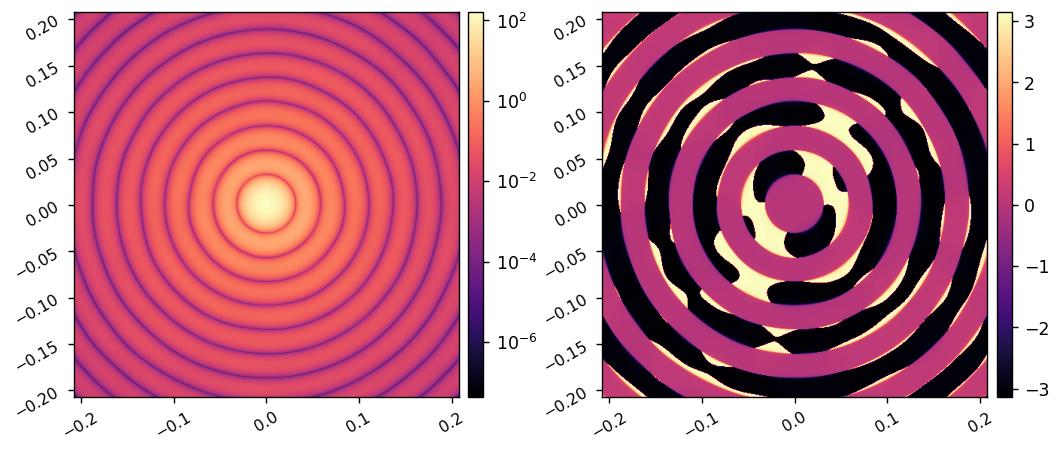

<Quantity 39.11885652 m>

<Quantity 39.11884119 m>

<Quantity 1.53312823e-05 m>

OutOfMemoryError: Out of memory allocating 4,294,967,296 bytes (allocated so far: 64,472,749,056 bytes).

In [6]:
npix = 512
oversample = 32
pupil_diam = m1_diam
PUPIL = poppy.CircularAperture(radius=pupil_diam/2)

fl_m1 = 3.652962023674745E+004/2*u.mm
fl_m2 = -3.636649801410836E+003/2*u.mm
fl_m3 = 3.463978665836946E+003/2*u.mm

m1 = poppy.QuadraticLens(fl_m1, name='M1')
m2 = poppy.QuadraticLens(fl_m2, name='M2')
m3 = poppy.QuadraticLens(fl_m3, name='M3')
m4 = poppy.ScalarTransmission()

fosys = poppy.FresnelOpticalSystem(pupil_diameter=pupil_diam, npix=npix, beam_ratio=1/oversample)
fosys.add_optic(PUPIL)
fosys.add_optic(m1)
fosys.add_optic(m1surf0)
fosys.add_optic(m2, distance=d_m1_m2)
fosys.add_optic(m2surf0)
fosys.add_optic(m3, distance=d_m2_m3)
fosys.add_optic(m3surf0)
fosys.add_optic(m4, distance=d_m3_m4)
fosys.add_optic(m4surf0)
fosys.add_optic(poppy.ScalarTransmission('Image'), distance=d_m4_fp + -0.0062856074*u.m)

_, fpwfs = fosys.calc_psf(wavelength=750*u.nm, 
                        return_final=True, 
#                         return_intermediates=True, 
                        normalize='none')
fpwf = fpwfs[-1]
imshow2(fpwf.intensity, fpwf.phase, lognorm1=True, npix=512, pxscl=fpwf.pixelscale.to_value(u.mm/u.pix))
display(fpwf.z_w0, fpwf.z, fpwf.z_w0-fpwf.z)

fosys.add_optic(poppy.QuadraticLens(224.99998119573664*u.m), distance=224.99998119573664*u.m -0.0016189331*u.m)
fosys.add_optic(poppy.ScalarTransmission('Image'), distance=224.99998119573664*u.m -0.0016189331*u.m)

_, ppwfs = fosys.calc_psf(wavelength=750*u.nm, 
                        return_final=True, 
#                         return_intermediates=True, 
                        normalize='none')
ppwf = ppwfs[-1]
imshow2(ppwf.amplitude, ppwf.phase, npix=npix, pxscl=ppwf.pixelscale.to_value(u.mm/u.pix))
display(ppwf.z_w0, ppwf.z, ppwf.z_w0-ppwf.z)

import misc_funs as misc
circ = misc.pad_or_crop(PUPIL.get_transmission(ppwf), npix)
amp = misc.pad_or_crop(ppwf.amplitude, npix)*circ
phs = misc.pad_or_crop(ppwf.phase, npix)*circ
phs += 2*np.pi/wavelength_c.to_value(u.m)*xp.array(wfe) # add the low-order wfe
opd = phs*wavelength_c.to_value(u.m)/2/np.pi
imshow3(circ, amp, opd, pxscl=ppwf.pixelscale.to_value(u.mm/u.pix))

dm_diam = 0.0102
data = xp.array([amp,opd])
misc.save_fits('ote-wfe-data/telescope_wfe.fits'.format(i), data=data, header={'PIXELSCL':dm_diam/npix})

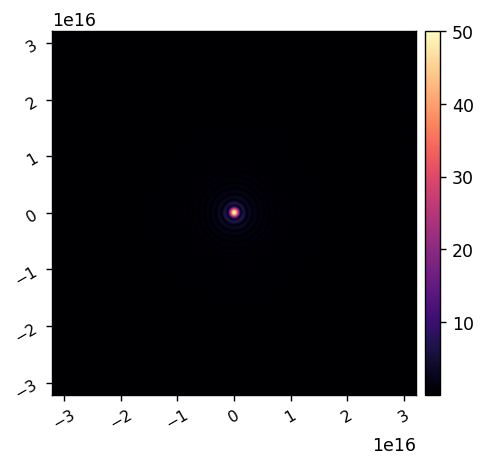

In [16]:
import copy
fpwf.propagate_fresnel(abs(fpwf.focal_length))
fpwf *= poppy.QuadraticLens(abs(fpwf.focal_length))
fpwf.propagate_fresnel(abs(fpwf.focal_length))

imshow1(fpwf.amplitude, npix=npix, pxscl=fpwf.pixelscale)

In [15]:
fpwf.__dir__()

['oversample',
 'wavelength',
 'diam',
 '_pixelscale_m',
 'planetype',
 '_image_centered',
 'wavefront',
 'ispadded',
 'history',
 'location',
 'current_plane_index',
 'units',
 'w_0',
 'z',
 'z_w0',
 'waists_w0',
 'waists_z',
 'spherical',
 'k',
 'rayleigh_factor',
 'focal_length',
 '_y',
 '_x',
 'n',
 '_display_hint_expected_nplanes',
 'angular_coordinates',
 '__module__',
 '__init__',
 'display',
 'z_r',
 'divergence',
 'param_str',
 'waists',
 '_fft',
 '_inv_fft',
 'r_c',
 'spot_radius',
 'pupil_coordinates',
 'coordinates',
 'pixelscale',
 'fov',
 'propagate_direct',
 'propagate_to',
 '_propagate_ptp',
 '_propagate_wts',
 '_propagate_stw',
 'planar_range',
 'propagate_fresnel',
 '__imul__',
 'apply_lens_power',
 'apply_image_plane_fftmft',
 '_resample_wavefront_pixelscale',
 'from_wavefront',
 '__doc__',
 '__abstractmethods__',
 '_abc_impl',
 '__slotnames__',
 '__str__',
 'copy',
 'normalize',
 '__mul__',
 '__rmul__',
 '__iadd__',
 '__add__',
 'as_fits',
 'writeto',
 '_display_aft

In [16]:
fpwf.diam

<Quantity 6.5 m>

In [12]:
fpwf.focal_length

<Quantity -224.9999812 m>

In [12]:
display(fpwfs[3].z_w0, fpwfs[3].z, fpwfs[3].z_w0-fpwfs[3].z)  

<Quantity 32.0721442 m>

<Quantity 16.6381291 m>

<Quantity 15.4340151 m>

In [13]:
fpwfs = 0
ppwfs = 0

# Make the loop to do this for all pointing samples generated

array([3.94284756e-07, 5.11243849e-07])

Oversampling > 2x suggested for reliable results in Fresnel propagation.
Oversampling > 2x suggested for reliable results in Fresnel propagation.


Ray Coordinates: [-1.52971226e-06  4.03015527e+03] [1.15715453e-04 3.88731485e+02] [1.40550034e-03 2.85006028e+02] [-1.9659182e-06 -3.8106557e+01]
Shifts: [1.52971226e-06 1.98310136e-06] [-0.00011572 -0.00015013] [-0.0014055  -0.00181718] [1.96591820e-06 7.70889699e-06]
Pixels to shift in x and y: -0.33855035330421823 -0.4392441787890025
Pixels to shift in x and y: -3.598080870856759 -4.651986385579221


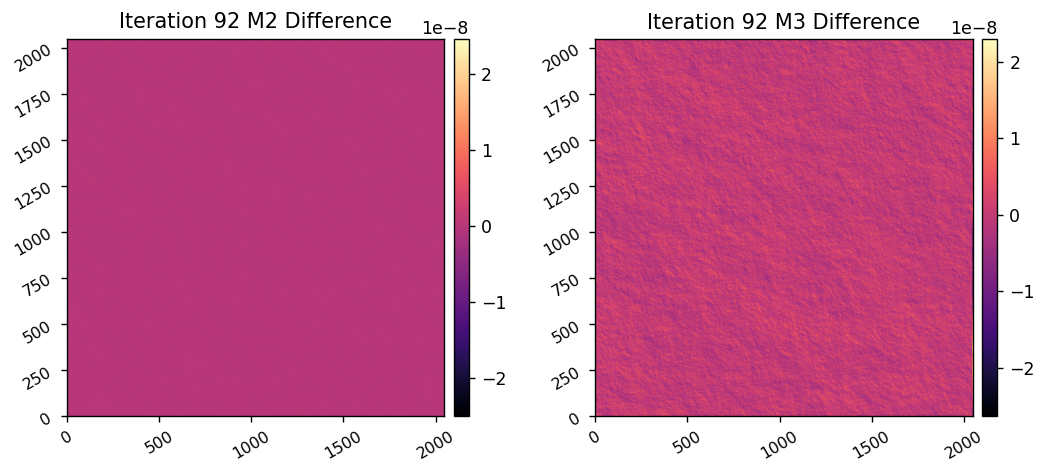

AttributeError: 'NoneType' object has no attribute 'GetResults'

In [14]:
import misc_funs as misc
import time
p = pointing.to(u.degree).value

for i in range(Nsamps):
    
    display(p[i])
    # ensure there is no system wide tilt applied at the CB
    tilt_about_x.set_Value(str(0))
    tilt_about_y.set_Value(str(0))

    hx = p[i][0]/H
    hy = p[i][1]/H

    # get the real ray coordinates on each optic
    m1_rx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m1_ind, 1, hx, hy, 0, 0, 0, 0)
    m1_ry = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m1_ind, 1, hx, hy, 0, 0, 0, 0)
    m1_ray = np.array([m1_rx,m1_ry])

    m2_rx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m2_ind, 1, hx, hy, 0, 0, 0, 0)
    m2_ry = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m2_ind, 1, hx, hy, 0, 0, 0, 0)
    m2_ray = np.array([m2_rx,m2_ry])

    m3_rx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m3_ind, 1, hx, hy, 0, 0, 0, 0)
    m3_ry = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m3_ind, 1, hx, hy, 0, 0, 0, 0)
    m3_ray = np.array([m3_rx,m3_ry])

    m4_rx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m4_ind, 1, hx, hy, 0, 0, 0, 0)
    m4_ry = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m4_ind, 1, hx, hy, 0, 0, 0, 0)
    m4_ray = np.array([m4_rx,m4_ry])
    print('Ray Coordinates:', m1_ray, m2_ray, m3_ray, m4_ray)

    m1_shift = m1_ray0 - m1_ray
    m2_shift = m2_ray0 - m2_ray
    m3_shift = m3_ray0 - m3_ray
    m4_shift = m4_ray0 - m4_ray
    print('Shifts:', m1_shift, m2_shift, m3_shift, m4_shift)
    
    m2surf = shift_surface_errors(m2surf0, npix_surfs, x_shift=m2_shift[0]*u.m, y_shift=m2_shift[1]*u.m)
#     imshow3(m2errs, m2surf.opd, m2errs-m2surf.opd)

    m3surf = shift_surface_errors(m3surf0, npix_surfs, x_shift=m3_shift[0]*u.m, y_shift=m3_shift[1]*u.m)
#     imshow3(m3errs, m3surf.opd, m3errs-m3surf.opd)
    
    imshow2(m2errs-m2surf.opd, m3errs-m3surf.opd, 
            'Iteration {:d} M2 Difference'.format(i), 'Iteration {:d} M3 Difference'.format(i))
    fosys = poppy.FresnelOpticalSystem(pupil_diameter=pupil_diam, npix=npix, beam_ratio=1/oversample)
    fosys.add_optic(PUPIL)
    fosys.add_optic(m1)
    fosys.add_optic(m1surf0)
    fosys.add_optic(m2, distance=d_m1_m2)
    fosys.add_optic(m2surf)
    fosys.add_optic(m3, distance=d_m2_m3)
    fosys.add_optic(m3surf)
    fosys.add_optic(m4, distance=d_m3_m4)
    fosys.add_optic(m4surf0)
    fosys.add_optic(poppy.ScalarTransmission('Image'), distance=d_m4_fp + -0.0062856074*u.m)
    fosys.add_optic(poppy.QuadraticLens(224.99998119573664*u.m), distance=224.99998119573664*u.m -0.0016189331*u.m)
    fosys.add_optic(poppy.ScalarTransmission('Image'), distance=224.99998119573664*u.m -0.0016189331*u.m)

    _, ppwf = fosys.calc_psf(wavelength=750*u.nm, 
                            return_final=True, 
    #                         return_intermediates=True, 
                            normalize='none')
    ppwf=ppwf[0]
#     imshow2(ppwf.amplitude, ppwf.phase, npix=npix, pxscl=ppwf.pixelscale.to_value(u.mm/u.pix))
    
    
    # apply system wide tilt using CB and get low-order errors
    tilt_about_x.set_Value(str(p[i][0]))
    tilt_about_y.set_Value(str(p[i][1]))

    WFMap = TheSystem.Analyses.New_Analysis(ZOSAPI.Analysis.AnalysisIDM.WavefrontMap)
#     WFMapSettings = WFMap.GetSettings()
#     WFMapSettings.Sampling = ZOSAPI.Analysis.SampleSizes.S_1024x1024

#     WFMap.ApplyAndWaitForCompletion() # make sure the settings have been applied
    WFMapResults = WFMap.GetResults() # get results

    wfe = np.flip(np.array(WFMapResults.GetDataGrid(0).Values)) * wave
    wfe[np.isnan(wfe)] = 0
    
    # put together the high and low-order wfe data
    circ = misc.pad_or_crop(PUPIL.get_transmission(ppwf), npix)
    amp = misc.pad_or_crop(ppwf.amplitude, npix)*circ
    phs = misc.pad_or_crop(ppwf.phase, npix)*circ
    phs += 2*np.pi/wavelength_c.to_value(u.m)*xp.array(wfe) # add the low-order wfe
    opd = phs*wavelength_c.to_value(u.m)/2/np.pi
    imshow3(circ, amp, opd, pxscl=ppwf.pixelscale.to_value(u.mm/u.pix))
    
    dm_diam = 0.0102
    data = xp.array([amp,opd])
    misc.save_fits('ote-wfe-data/telescope_wfe_{:d}.fits'.format(i), data=data, header={'PIXELSCL':dm_diam/npix})
#     misc.save_fits('ote-wfe-data/telescope_wfe_amp_{:d}.fits'.format(i), data=amp, header={'PIXELSCL':dm_diam/npix})
#     misc.save_fits('ote-wfe-data/telescope_wfe_opd_{:d}.fits'.format(i), data=opd, header={'PIXELSCL':dm_diam/npix})
    time.sleep(1)
    clear_output(wait=True)

In [16]:
WFMap.GetSettings()

AttributeError: 'NoneType' object has no attribute 'GetSettings'

In [20]:
WFMap = TheSystem.Analyses.New_Analysis(ZOSAPI.Analysis.AnalysisIDM.WavefrontMap)
display(WFMap)

None

In [24]:
print(TheSystem.Analyses.New_Analysis(ZOSAPI.Analysis.AnalysisIDM.WavefrontMap))

None




# Compare two of the files to make sure irt worked

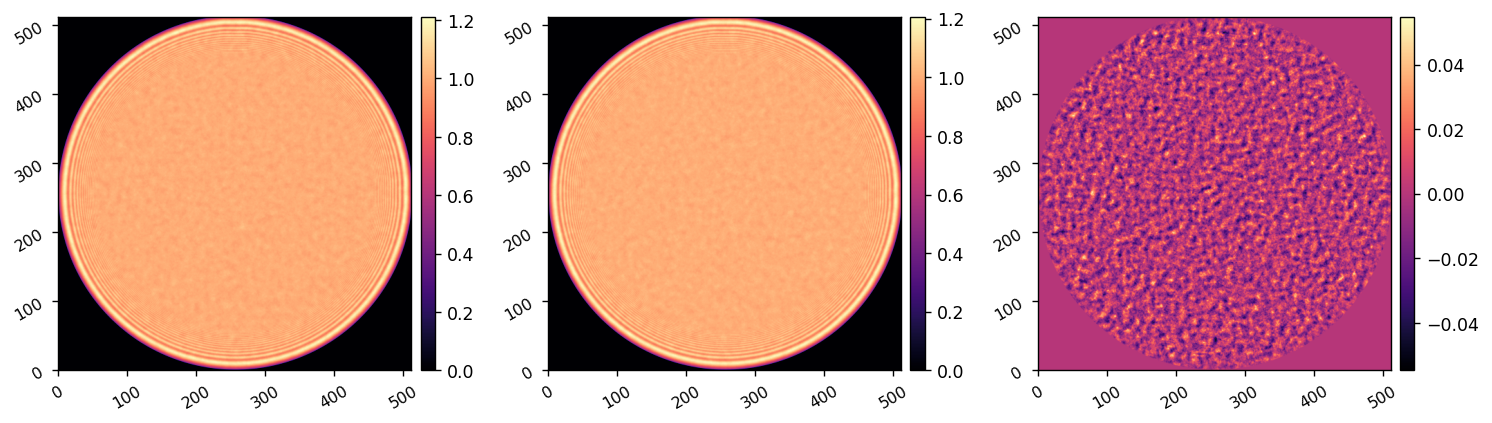

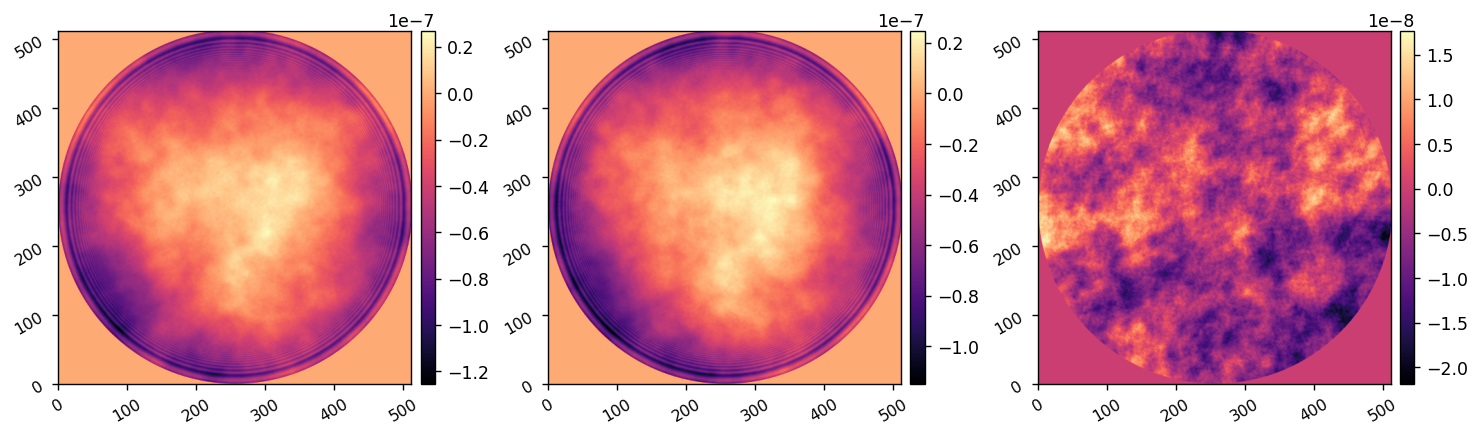

In [12]:
amp1 = fits.getdata('ote-wfe-data/telescope_wfe_1.fits')[0]
amp2 = fits.getdata('ote-wfe-data/telescope_wfe_4.fits')[0]
imshow3(amp1, amp2, amp1-amp2)

opd1 = fits.getdata('ote-wfe-data/telescope_wfe_1.fits')[1]
opd2 = fits.getdata('ote-wfe-data/telescope_wfe_4.fits')[1]
imshow3(opd1, opd2, opd1-opd2)